# Looked After Children (LAC) - Demographic Analysis

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
plt.style.use('tableau-colorblind10')
color='#702A7D'
grey_color = '#A9A9A9'


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

In [2]:
lac_query = """
SELECT
  a.person_id, a.YearOfBirth
  ,a.PCArea_Home AS PCArea, a.EthnicOrigin
  ,a.StartDate, a.EndDate
  ,p.birth_datetime AS DateOfBirth
  ,p.gender_source_value AS Gender
FROM
    yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiC AS a
LEFT JOIN
    yhcr-prd-bradfor-bia-core.CB_2649.person AS p
ON
    a.person_id = p.person_id
"""

In [3]:
lac = pandas_gbq.read_gbq(lac_query)
lac.info()

Downloading: 100%|██████████|
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1920 non-null   object             
 1   YearOfBirth   1920 non-null   Int64              
 2   PCArea        1920 non-null   object             
 3   EthnicOrigin  1920 non-null   object             
 4   StartDate     1920 non-null   dbdate             
 5   EndDate       963 non-null    dbdate             
 6   DateOfBirth   1914 non-null   datetime64[us, UTC]
 7   Gender        1913 non-null   object             
dtypes: Int64(1), datetime64[us, UTC](1), dbdate(2), object(4)
memory usage: 122.0+ KB


# Import Project functions

In [4]:
import sys
sys.path.append('../code')

from data_cleaning import fill_missing_dob, convert_dates_datatype, drop_duplicates, gender_mapping

from demographic_analysis_helpers import (
    analyse_person_ids,
    add_calculated_columns,
    plot_distributions,
    plot_age_distribution,
    plot_monthly_trends,
    plot_monthly_entries_exits,
    plot_running_total_in_intervention,
    plot_duration_in_intervention,
    plot_average_duration_by_age,
    plot_median_duration_by_age,
    plot_median_intervention_duration_over_time 
)

In [5]:
# Fill Missing DoB
lac = fill_missing_dob(lac, 'YearOfBirth', 'DateOfBirth')

# Convert Date columns datatype
date_columns = ['StartDate', 'DateOfBirth', 'EndDate']
lac = convert_dates_datatype(lac, date_columns)

# Drop duplicates
drop_duplicates(lac)

# Clean Gender column
gender_mapping(lac, 'Gender')

# Add calculated columns
lac = add_calculated_columns(lac)

lac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 1919
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   person_id                    1917 non-null   object        
 1   YearOfBirth                  1917 non-null   Int64         
 2   PCArea                       1917 non-null   object        
 3   EthnicOrigin                 1917 non-null   object        
 4   StartDate                    1917 non-null   datetime64[ns]
 5   EndDate                      961 non-null    datetime64[ns]
 6   DateOfBirth                  1917 non-null   datetime64[us]
 7   Gender                       1899 non-null   object        
 8   AgeAtEntry                   1917 non-null   int64         
 9   num_of_days_in_intervention  961 non-null    Int64         
 10  entry_agegroup               1423 non-null   category      
dtypes: Int64(2), category(1), datetime64[ns](2), dat

## Exploratory Analysis

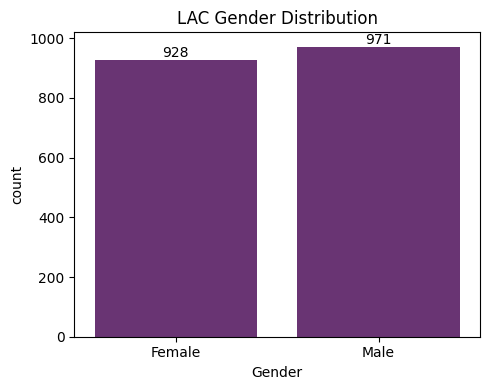

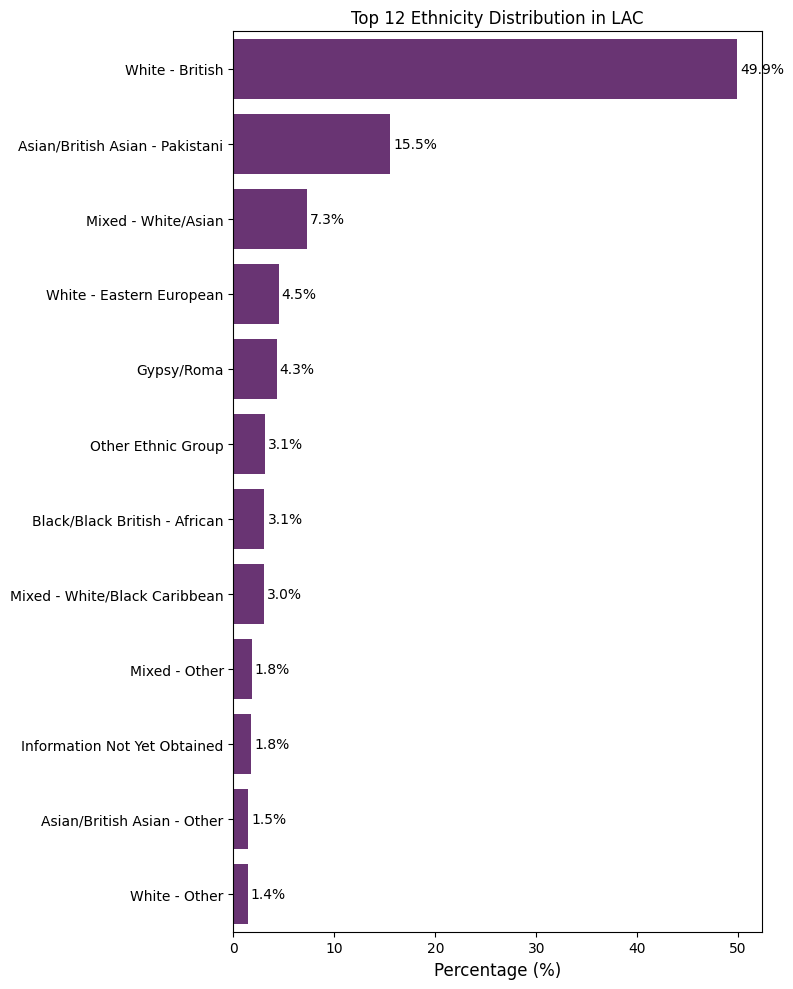

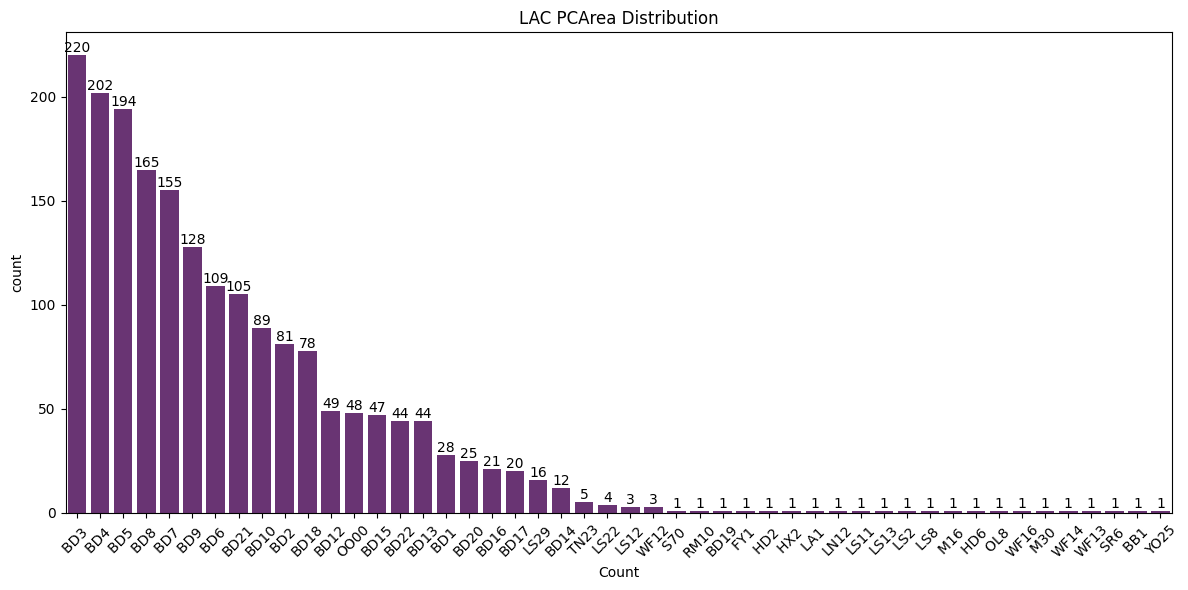

In [6]:
# Plot Categorical Distributions
plot_distributions(lac, 'LAC')

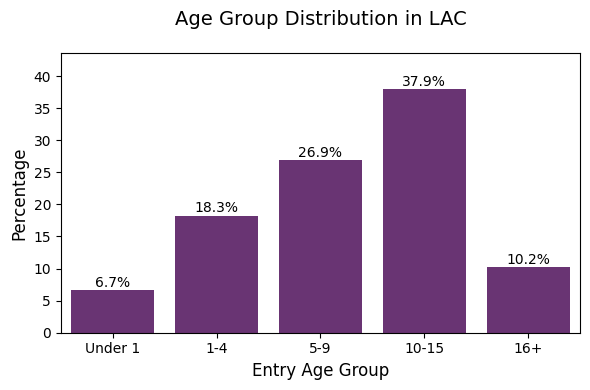

In [7]:
# Plot age distribution
plot_age_distribution(lac, 'LAC')

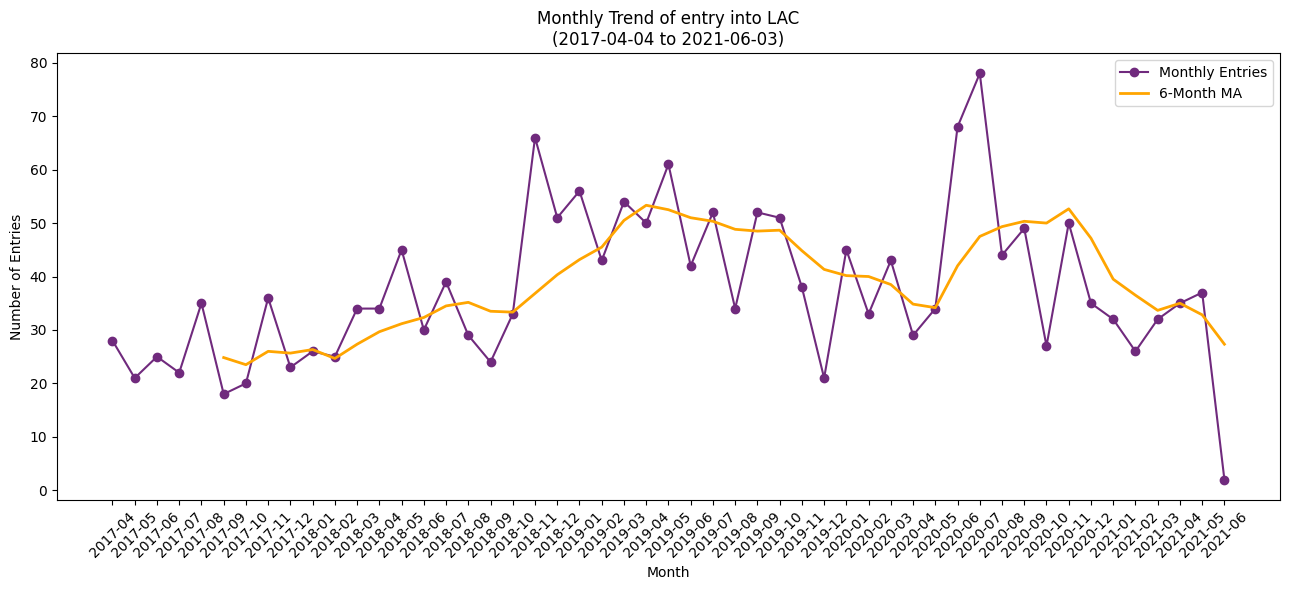

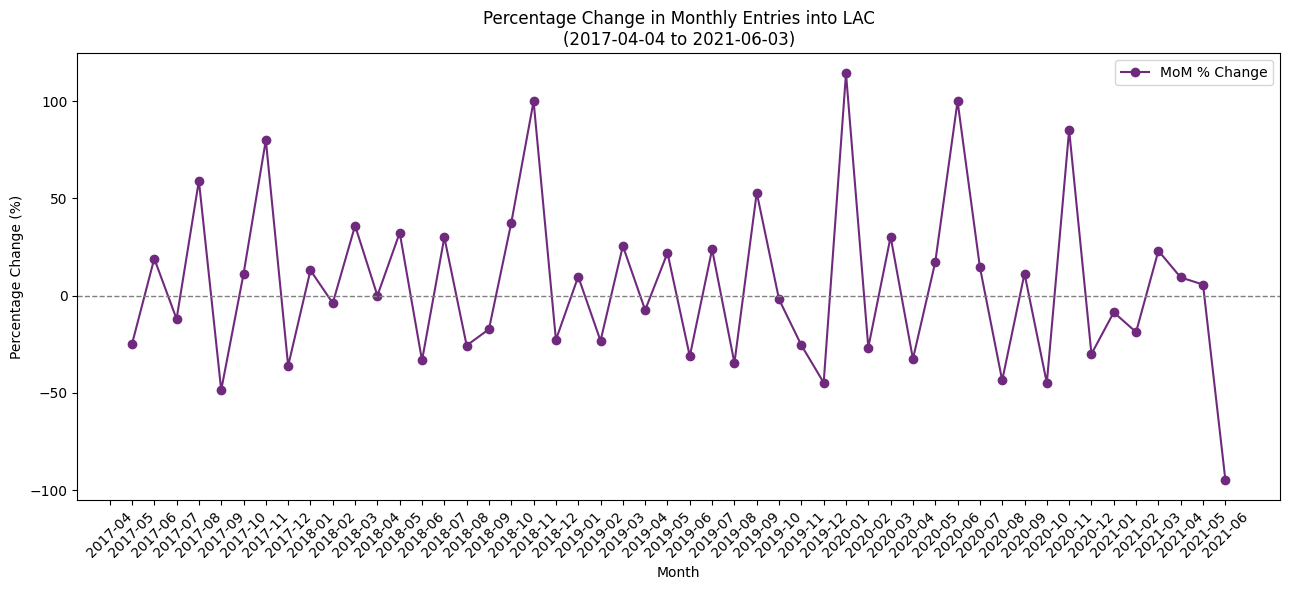

In [8]:
# Plot monthly trends
plot_monthly_trends(lac, 'LAC', 'StartDate')

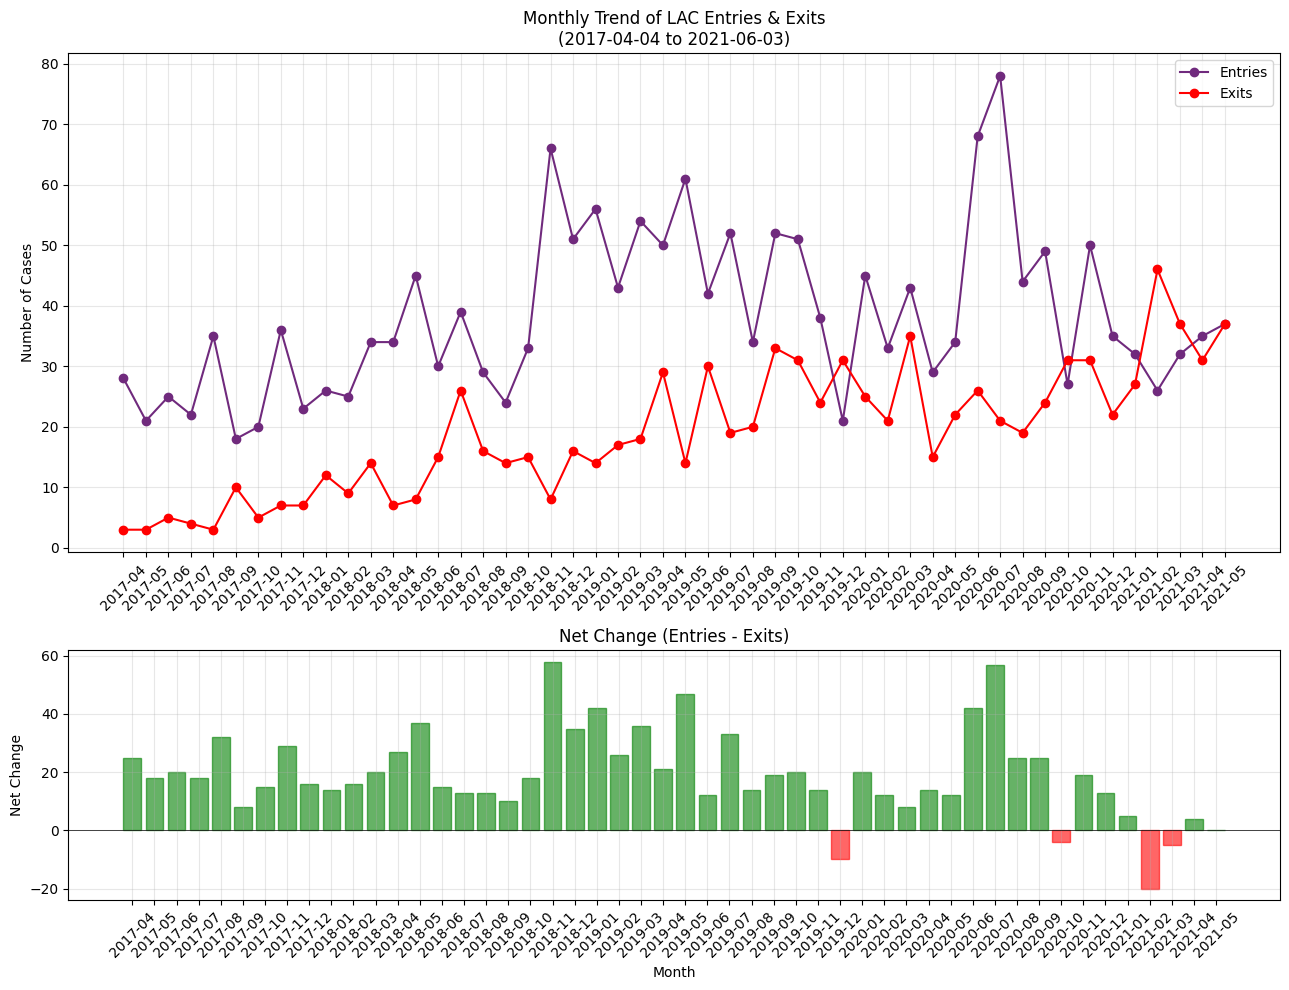


Summary of Net Changes for LAC:
Average monthly net change: 19.2
Maximum increase: 58
Maximum decrease: -20
Months with net increase: 45
Months with net decrease: 4


In [9]:
# Plot monthly entries and exits trends
plot_monthly_entries_exits(lac, 'StartDate', 'EndDate', 'LAC')

## Entries into LAC for Each Financial Year

In [10]:
# Define financial years
financial_years = [
    ('2017/04-2018/03', '2017-04-01', '2018-03-31'),
    ('2018/04-2019/03', '2018-04-01', '2019-03-31'),
    ('2019/04-2020/03', '2019-04-01', '2020-03-31'),
    ('2020/04-2021/03', '2020-04-01', '2021-03-31')
]

# Calculate entries for each financial year
entries_by_fy = []
for fy_label, start_date, end_date in financial_years:
    mask = (lac['StartDate'] >= start_date) & (lac['StartDate'] <= end_date)
    lac_entries = lac[mask].shape[0]
    entries_by_fy.append({
        'Financial Year': fy_label,
        'Total Entries': lac_entries
    })

# Create a DataFrame for the results
result_df = pd.DataFrame(entries_by_fy)

# Display as a formatted table
print("\nTotal Entries by Financial Year:")
result_df


Total Entries by Financial Year:


,Financial Year,Total Entries
0,2017/04-2018/03,313
1,2018/04-2019/03,504
2,2019/04-2020/03,522
3,2020/04-2021/03,504


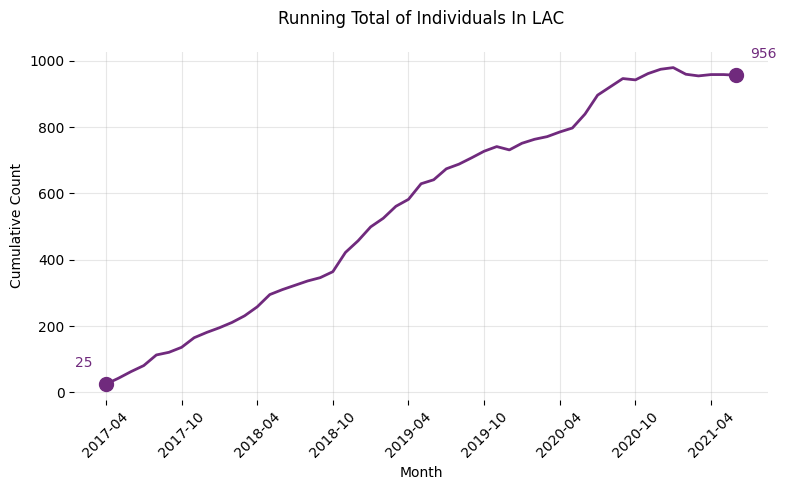

In [11]:
# Plot demand in intervention
plot_running_total_in_intervention(lac, 'StartDate', 'EndDate', 'LAC')

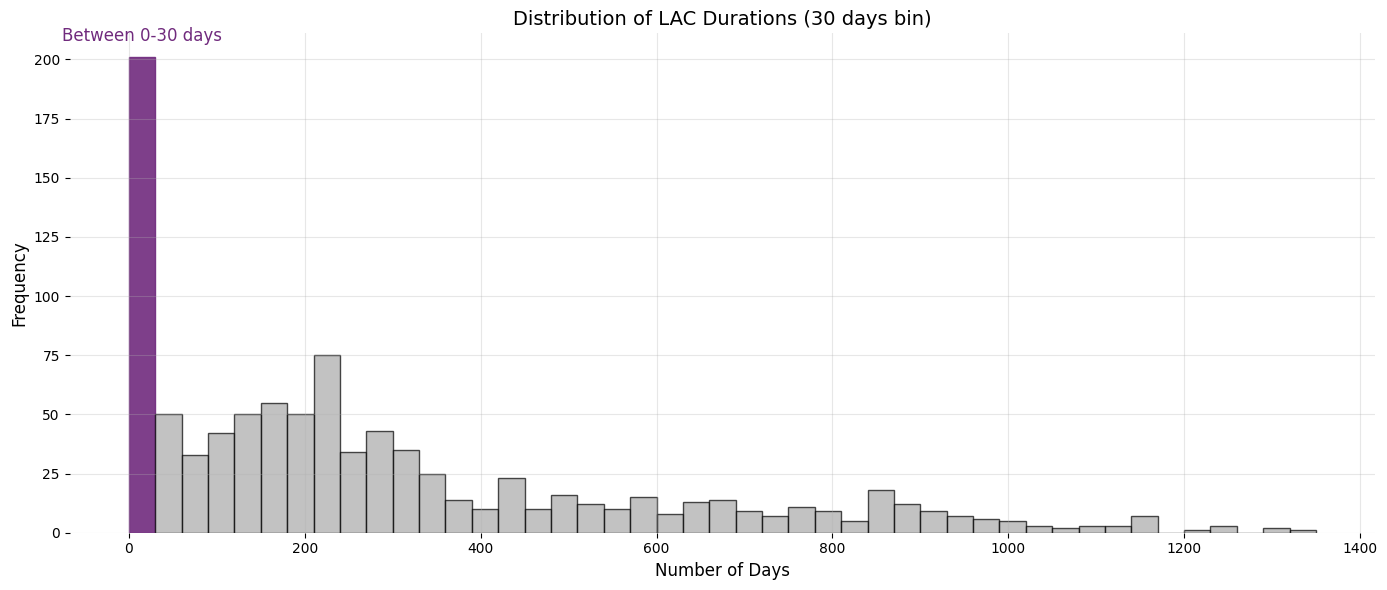

In [12]:
# Plot duration in intervention
plot_duration_in_intervention(lac, 'StartDate', 'EndDate', 'LAC')

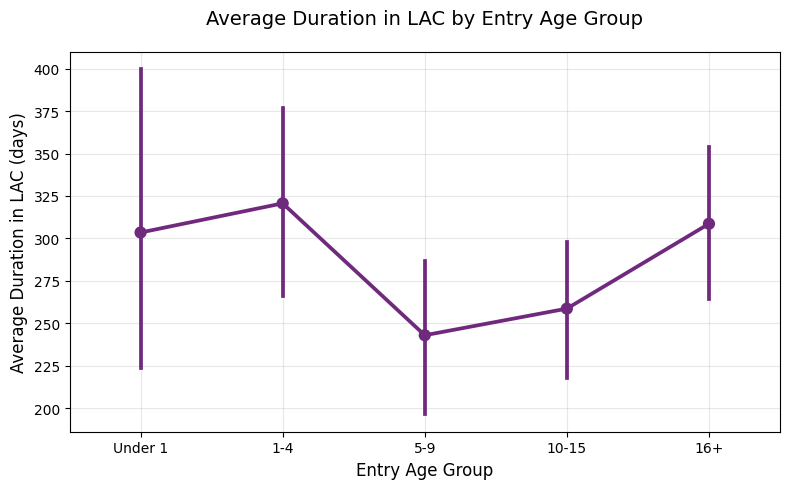

In [13]:
# # Plot average duration in intervention
plot_average_duration_by_age(lac, 'LAC')

In [14]:
lac.loc[lac['AgeAtEntry'] > 18]

,person_id,YearOfBirth,PCArea,EthnicOrigin,StartDate,EndDate,DateOfBirth,Gender,AgeAtEntry,num_of_days_in_intervention,entry_agegroup,YearMonth


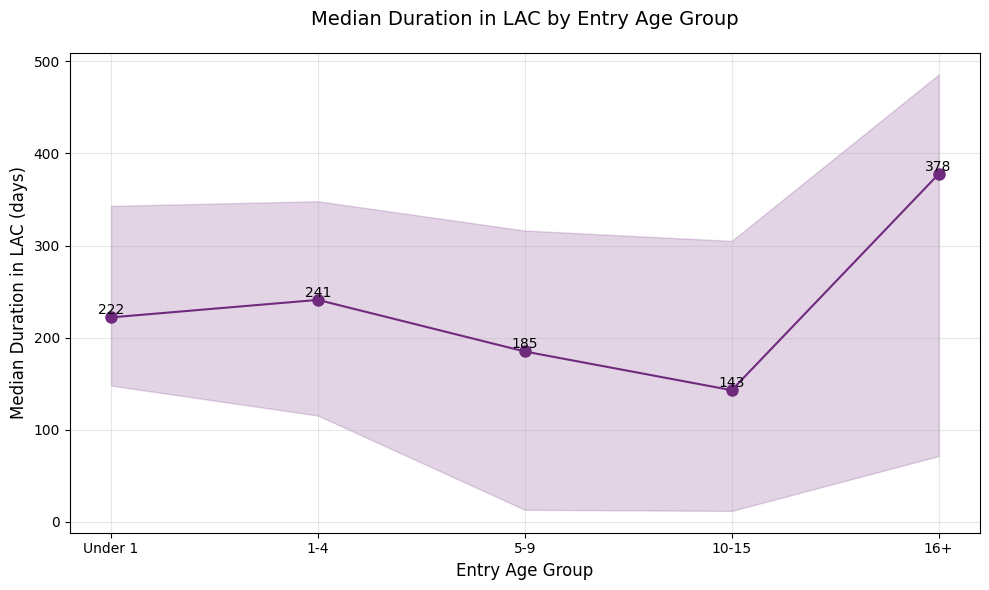

In [15]:
# Plot median duration by age group
plot_median_duration_by_age(lac, 'LAC')

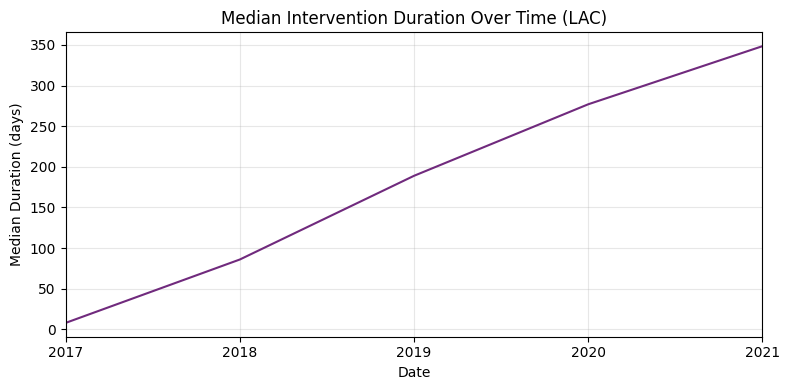

In [16]:
# Plot median duration over time
plot_median_intervention_duration_over_time(lac, 'LAC', 'EndDate',
                                                'num_of_days_in_intervention',
                                                time_freq='Y')